# Clickbait detector with BERT classifier



This notebook is splitted in different sections:
1. Importing required libraries
2. EDA to understand the variable postText and the label distribution
3. Building the BERT model
4. BERT Evaluation
5. EDA and Feature Engineering additional features
6. Combining BERT output with other models
7. Final Evaluation 
8. Error Analysis 
9. To do list in order to enhance this model
10. References

## 1) Importing required libraries

In [1]:
#general libraries for data science, EDA and NLP
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
# general use libraries
import random
import warnings
import time
import datetime

In [2]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

In [3]:
# importing natual language toolkit to process text information
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('avegered_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability  import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading avegered_perceptron_tagger: Package
[nltk_data]     'avegered_perceptron_tagger' not found in index
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!pip install transformers

In [5]:
# installing transformers library to use BERT Classification model
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
# we use torch to make better use of GPU: http://torch.ch/
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


In [6]:
# Setting seeds for consistent results
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## 2) EDA to understand the variable postText and the label


First of all, let's check from where is coming this dataset, we've made a brief investigation on the webis website: https://webis.de/events/clickbait-challenge/shared-task.html

"The Webis Clickbait Corpus 2017 comprises a total of 38,517 Twitter posts from 27 major US news publishers. In addition to the posts, information about the articles linked in the posts are included. The posts had been published between November 2016 and June 2017. To avoid publisher and topical biases, a maximum of ten posts per day and publisher were sampled. All posts were annotated on a 4-point scale [not click baiting (0.0), slightly click baiting (0.33), considerably click baiting (0.66), heavily click baiting (1.0)] by five annotators from Amazon Mechanical Turk. A total of 9,276 posts are considered clickbait by the majority of annotators. In terms of its size, this corpus outranges the Webis Clickbait Corpus 2016 by one order of magnitude. The corpus is divided into two logical parts, a training and a test dataset."



In [7]:
# Reading the dataset from an input folder
train = pd.read_csv('input/webis_train.csv')
test = pd.read_csv('input/webis_test.csv')

In [8]:
# Duplicates and NAN Values 
print(train[train.duplicated()])
print(test[test.duplicated()])


Empty DataFrame
Columns: [Unnamed: 0, postMedia, postText, id, targetCaptions, targetParagraphs, targetTitle, postTimestamp, targetKeywords, targetDescription, truthJudgments, truthMean, truthClass, truthMedian, truthMode]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, id, postMedia, targetCaptions, postText, postTimestamp, targetTitle, targetDescription, targetKeywords, targetParagraphs, truthJudgments, truthClass, truthMedian, truthMode, truthMean]
Index: []


In [9]:
print(train.isnull().sum())

Unnamed: 0              0
postMedia               0
postText               54
id                      0
targetCaptions          0
targetParagraphs        0
targetTitle             0
postTimestamp           0
targetKeywords       7229
targetDescription     943
truthJudgments          0
truthMean               0
truthClass              0
truthMedian             0
truthMode               0
dtype: int64


In [10]:
print(test.isnull().sum())

Unnamed: 0              0
id                      0
postMedia               0
targetCaptions          0
postText               66
postTimestamp           0
targetTitle             0
targetDescription     924
targetKeywords       7054
targetParagraphs        0
truthJudgments          0
truthClass              0
truthMedian             0
truthMode               0
truthMean               0
dtype: int64


In [11]:
train[train["postText"].isnull()].head()

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
261,261,[],NaN,850909692721332224,['Sean Penn on His Former Producer Steve Banno...,['Attorney General Jeff Sessions issued a stat...,Jeff Sessions Slams Deal to Monitor Baltimore ...,Sun Apr 09 03:14:14 +0000 2017,"Attorney General Jeff Session, Baltimore, Fred...",Jeff Sessions Slams Deal to Monitor Baltimore ...,"[1.0, 1.0, 1.0, 0.33333333330000003, 0.6666666...",0.800000,clickbait,1.0,1.0
281,281,[],NaN,850321382714028032,['Trump Xi Jinping dinner Mar-a-Lago Syria Ass...,['President Donald Trump ordered Tomahawk miss...,"Trump Ordered Syria Attack, then Ate Dinner wi...",Fri Apr 07 12:16:30 +0000 2017,"airstrikes, Assad, Chinese President Xi Jinpin...",President Donald Trump ordered the attack agai...,"[1.0, 0.33333333330000003, 1.0, 1.0, 1.0]",0.866667,clickbait,1.0,1.0
287,287,[],NaN,849966939820748800,"['trump', 'U.S. Illegal Immigration Plunges on...",['President Donald Trump ridiculed former Nati...,Donald Trump Ridicules ‘Horrible’ Susan Rice I...,Thu Apr 06 12:48:04 +0000 2017,"Andrea Mitchell, Hillary Clinton, MSNBC, Natio...",President Donald Trump ridiculed former Nation...,"[1.0, 1.0, 1.0, 0.33333333330000003, 1.0]",0.866667,clickbait,1.0,1.0
305,305,[],NaN,849445548553842688,['White House: ‘Heinous’ Syria Chemical Attack...,"['During Congressional testimony Tuesday, a fo...",Illegal Immigration Fell 67 Percent under Trum...,Wed Apr 05 02:16:15 +0000 2017,",Big Government, Breitbart Texas, Immigration,...",A former border commissioner claimed that ille...,"[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.0,1.0
308,308,[],NaN,849364334832750592,['Rand Paul: Susan Rice ‘Ought to Be Under Sub...,"['Using the hashtag #PutObamaUnderOath, best-s...",Ann Coulter: Obama Should Testify Under Oath o...,Tue Apr 04 20:53:32 +0000 2017,"Ann Coulter, Michelle Obama, Obama, surveillan...","Using the hashtag #PutObamaUnderOath, best-sel...","[0.33333333330000003, 1.0, 1.0, 0.0, 1.0]",0.666667,clickbait,1.0,1.0


There aren't duplicate values in train/test datasets. 

There are some empty texts in both train () and test () dataset, we will not remove these entries from train set as we need to perform predictions on empty texts as well for the test set. The most part of empty observations are clickbaits.

In [12]:
# Converting postText into string format
train["text"] = train["postText"].astype(str)
test["text"] = test["postText"].astype(str)

In [13]:
# Splitting the data for different purposes postText feature and the remaining features
train_text = train[["text", "truthClass"]]
test_text = test[["text", "truthClass"]]

# We are not taken into account some features as target keywords as we don't know if we are having this information in a real production environment
# We are also processing postText column as text information for this task, so we will ignore others features for the moment
train_feat = train[["postMedia", "postTimestamp", "truthClass"]]
test_feat = test[["postMedia", "postTimestamp", "truthClass"]]

In [14]:
train_text.head()

,text,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


##### Let's do some cleaning before exploratory data analysis
we will do the following for this purpose:
- Remove urls, emojis, html tags and punctutations,
- Tokenized the tweet base texts
- Lower Case the text
- Remove stopwords
- Applying word lemmatizer
 - Apply speech tags
 - Convert these tags into wordnet format
 - Applying word lemmatizer
- Convert tokenized text into a string

In [15]:
# Functions for cleaning
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


train_text['text_clean'] = train_text['text'].apply(lambda x: remove_URL(x))
train_text['text_clean'] = train_text['text_clean'].apply(lambda x: remove_emoji(x))
train_text['text_clean'] = train_text['text_clean'].apply(lambda x: remove_html(x))
train_text['text_clean'] = train_text['text_clean'].apply(lambda x: remove_punct(x))

In [16]:
# Tokenization & Stopwords
train_text['tokenized'] = train_text['text_clean'].apply(word_tokenize)
train_text['lower'] = train_text["tokenized"].apply(lambda x: [word.lower() for word in x])
stop = set(stopwords.words('english'))
train_text["stopwords_removed"] = train_text['lower'].apply(lambda x: [word for word in x if word not in stop])

In [17]:
# Applying TAGS
nltk.download('averaged_perceptron_tagger')
train_text['pos_tags'] = train_text['stopwords_removed'].apply(nltk.tag.pos_tag)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [18]:
# We are using wordnet corpus to preprocess the words before the lemmatization https://en.wikipedia.org/wiki/WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

train_text['wordnet_pos'] = train_text['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [19]:
# Applying lemmatization
wnl = WordNetLemmatizer()

train_text['lemmatized'] = train_text['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train_text['lemmatized'] = train_text['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])


train_text.head()

,text,truthClass,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,UK’s response to modern slavery leaving victim...,no-clickbait,UK’s response to modern slavery leaving victim...,"[UK, ’, s, response, to, modern, slavery, leav...","[uk, ’, s, response, to, modern, slavery, leav...","[uk, ’, response, modern, slavery, leaving, vi...","[(uk, JJ), (’, NNP), (response, NN), (modern, ...","[(uk, a), (’, n), (response, n), (modern, a), ...","[uk, ’, response, modern, slavery, leave, vict..."
1,this is good,clickbait,this is good,"[this, is, good]","[this, is, good]",[good],"[(good, JJ)]","[(good, a)]",[good]
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,The forgotten Trump roast Relive his brutal 20...,"[The, forgotten, Trump, roast, Relive, his, br...","[the, forgotten, trump, roast, relive, his, br...","[forgotten, trump, roast, relive, brutal, 2004...","[(forgotten, JJ), (trump, NN), (roast, NN), (r...","[(forgotten, a), (trump, n), (roast, n), (reli...","[forgotten, trump, roast, relive, brutal, 2004..."
3,Meet the happiest #dog in the world!,clickbait,Meet the happiest dog in the world,"[Meet, the, happiest, dog, in, the, world]","[meet, the, happiest, dog, in, the, world]","[meet, happiest, dog, world]","[(meet, NN), (happiest, JJS), (dog, NN), (worl...","[(meet, n), (happiest, a), (dog, n), (world, n)]","[meet, happy, dog, world]"
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,Tokyos subway is shut down amid fears over an ...,"[Tokyos, subway, is, shut, down, amid, fears, ...","[tokyos, subway, is, shut, down, amid, fears, ...","[tokyos, subway, shut, amid, fears, imminent, ...","[(tokyos, JJ), (subway, NN), (shut, NN), (amid...","[(tokyos, a), (subway, n), (shut, n), (amid, n...","[tokyos, subway, shut, amid, fear, imminent, n..."


In [20]:
# Recovering string format
train_text['lemma_str'] = train_text['lemmatized']
for idx in range(0, len(train_text['lemmatized'])):
  train_text['lemma_str'][idx] = ' '.join(map(str, train_text['lemmatized'][idx]))

In [21]:
train_text.head()

,text,truthClass,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,UK’s response to modern slavery leaving victim...,no-clickbait,UK’s response to modern slavery leaving victim...,"[UK, ’, s, response, to, modern, slavery, leav...","[uk, ’, s, response, to, modern, slavery, leav...","[uk, ’, response, modern, slavery, leaving, vi...","[(uk, JJ), (’, NNP), (response, NN), (modern, ...","[(uk, a), (’, n), (response, n), (modern, a), ...","[uk, ’, response, modern, slavery, leave, vict...",uk ’ response modern slavery leave victim dest...
1,this is good,clickbait,this is good,"[this, is, good]","[this, is, good]",[good],"[(good, JJ)]","[(good, a)]",[good],good
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,The forgotten Trump roast Relive his brutal 20...,"[The, forgotten, Trump, roast, Relive, his, br...","[the, forgotten, trump, roast, relive, his, br...","[forgotten, trump, roast, relive, brutal, 2004...","[(forgotten, JJ), (trump, NN), (roast, NN), (r...","[(forgotten, a), (trump, n), (roast, n), (reli...","[forgotten, trump, roast, relive, brutal, 2004...",forgotten trump roast relive brutal 2004 thras...
3,Meet the happiest #dog in the world!,clickbait,Meet the happiest dog in the world,"[Meet, the, happiest, dog, in, the, world]","[meet, the, happiest, dog, in, the, world]","[meet, happiest, dog, world]","[(meet, NN), (happiest, JJS), (dog, NN), (worl...","[(meet, n), (happiest, a), (dog, n), (world, n)]","[meet, happy, dog, world]",meet happy dog world
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,Tokyos subway is shut down amid fears over an ...,"[Tokyos, subway, is, shut, down, amid, fears, ...","[tokyos, subway, is, shut, down, amid, fears, ...","[tokyos, subway, shut, amid, fears, imminent, ...","[(tokyos, JJ), (subway, NN), (shut, NN), (amid...","[(tokyos, a), (subway, n), (shut, n), (amid, n...","[tokyos, subway, shut, amid, fear, imminent, n...",tokyos subway shut amid fear imminent north ko...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


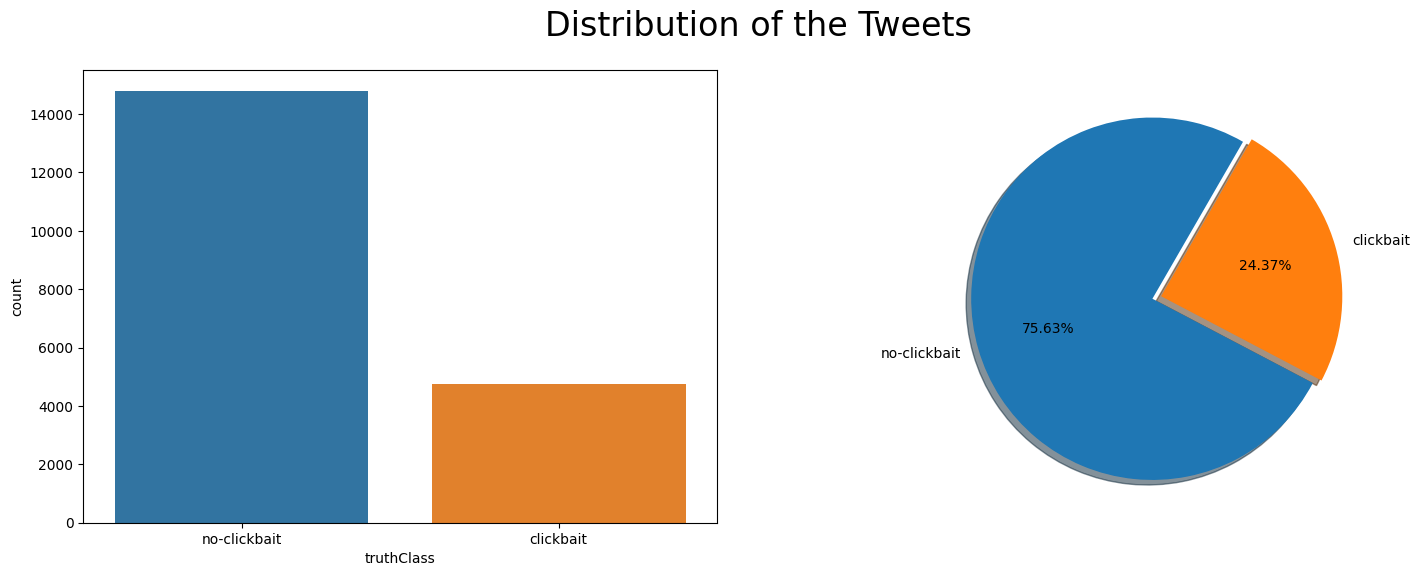

In [22]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train_text['truthClass'], ax=axes[0])
axes[1].pie(train_text['truthClass'].value_counts(),
            labels=['no-clickbait', 'clickbait'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

We can see that there are more no-clickbait and clickbait, the training dataset is not balanced, therefore we would need to use a metric as F1-score so the classifier can perform more balanced predictions

In [23]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('no-clickbait')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('clickbait')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


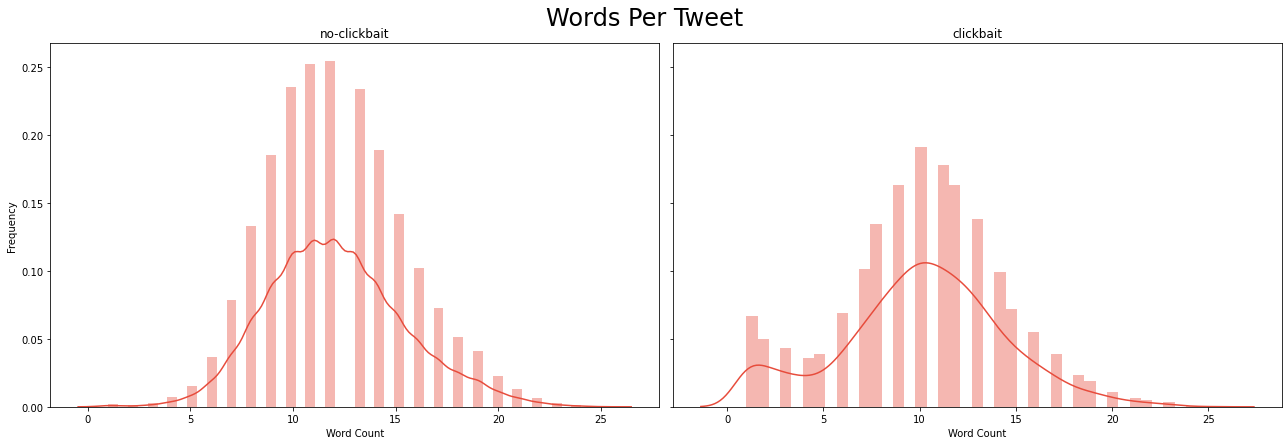

In [24]:
plot_word_number_histogram(train_text[train_text['truthClass'] == "no-clickbait"]['text'],
                           train_text[train_text['truthClass'] == "clickbait"]['text'])

It looks like the number of words per tweet are normally distributed, we can also see that in case of clickbait there are more cases with less words than non-clickbait

In [25]:
def plot_word_len_histogram(textno, textye):
    
    """A function for comparing average word length"""
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('no-clickbait')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('click-bait')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


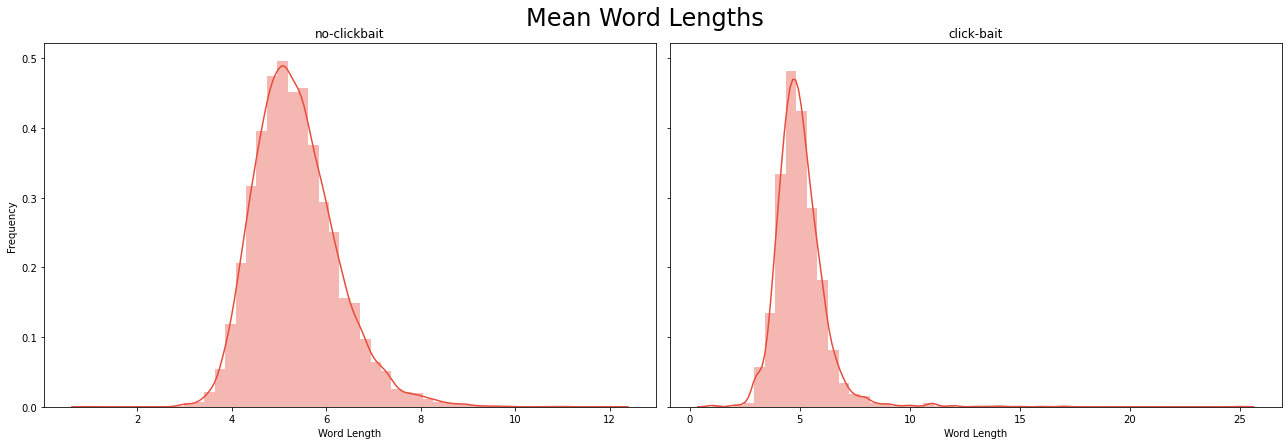

In [26]:
plot_word_len_histogram(train_text[train_text['truthClass'] == "no-clickbait"]['text'],
                           train_text[train_text['truthClass'] == "clickbait"]['text'])

The length of words is sighlitly different in case of clickbait, we can see a normal distribution with in both cases but different kurtosis

In [27]:
list_labels = [
    train_text[train_text['truthClass'] == "no-clickbait"]['lemma_str'],
    train_text[train_text['truthClass'] == "clickbait"]['lemma_str']
]

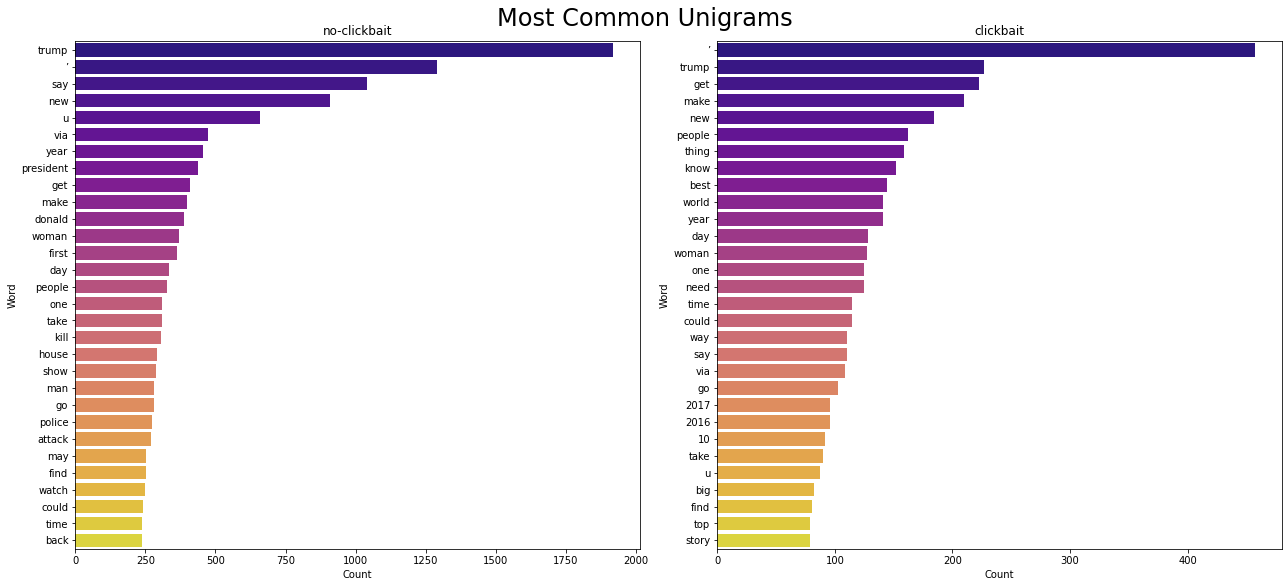

In [28]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(list_labels, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)

axes[0].set_title('no-clickbait')

axes[1].set_title('clickbait')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

The most commong unigrams are trump and ', this is not surprising taken into account that the news are generated by major US publishers in 2016 and 2017. Also there are quite similar words mostly repeated as woman and get. It's interesting that in case of clickbaits we have the dates 2016-2017 within the text.

In [29]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(list_labels, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('no-clickbait')
        axes[1].set_title('clickbait')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

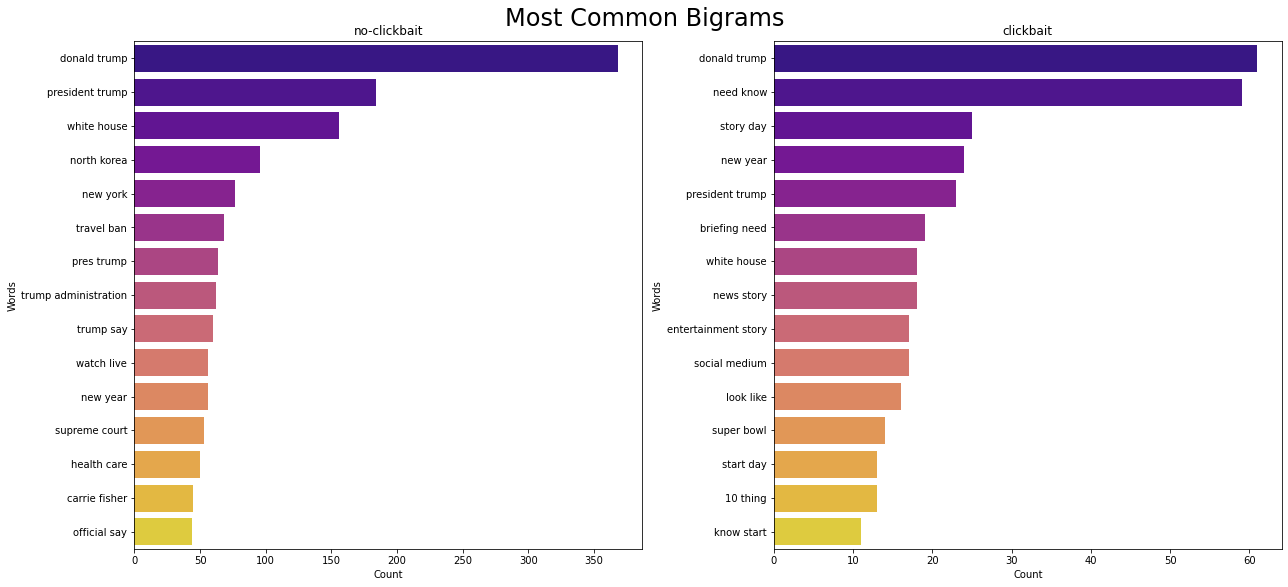

In [30]:
ngrams(2, 'Most Common Bigrams')

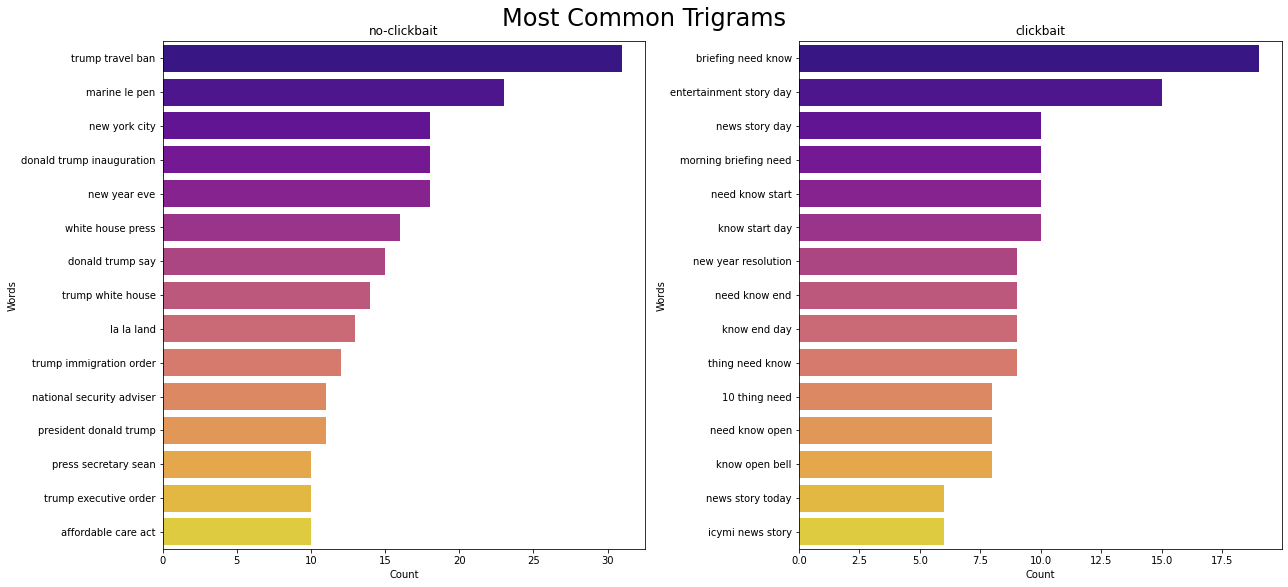

In [31]:
ngrams(3, 'Most Common Trigrams')

In the cases of 2-gram we are not able to detect main differences, but in case of 3-grams we can see that there are some interesting words within the tri-grams as: know, need and news.

##3) Building the BERT model

In [32]:
# If there's a GPU available...

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [33]:
print(f'Number of training tweets: {train_text.shape[0]}\n')
print(f'Number of testing tweets: {test_text.shape[0]}\n')

Number of training tweets: 19538

Number of testing tweets: 18979



In [34]:
pd.concat([train_text["text"], test_text["text"]])

0        UK’s response to modern slavery leaving victim...
1                                             this is good
2        The "forgotten" Trump roast: Relive his brutal...
3                     Meet the happiest #dog in the world!
4        Tokyo's subway is shut down amid fears over an...
                               ...                        
18974    Whitney Tilson on Trump's supporters: 'I think...
18975    The McDonald’s franchisee who created the Big ...
18976    Colombian Congress passes second #FARC peace d...
18977    Australian startups need more diversity to thr...
18978    35 gifts for the wanderlust-obsessed person in...
Name: text, Length: 38517, dtype: object

In [35]:
# Retrieve train labels in a separate numpy array & concatenate train/test texts
labels = train['truthClass'].values
idx = len(labels)
combined = pd.DataFrame()
combined["text"] = pd.concat([train_text["text"], test_text["text"]])
combined = combined.text.values

In [36]:
# We need to tokenize our text to pass the information into BERT classifier, for this task we using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [37]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  UK’s response to modern slavery leaving victims destitute while abusers go free
Tokenized:  ['uk', '’', 's', 'response', 'to', 'modern', 'slavery', 'leaving', 'victims', 'des', '##ti', '##tute', 'while', 'abuse', '##rs', 'go', 'free']
Token IDs:  [2866, 1521, 1055, 3433, 2000, 2715, 8864, 2975, 5694, 4078, 3775, 24518, 2096, 6905, 2869, 2175, 2489]


In [38]:
max_len = 0

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    # The first token of every sequence is always a special classification token ([CLS])
    # Then it adds [SEP] tokens for making BERT decide if sentences are related

    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  104


In [39]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


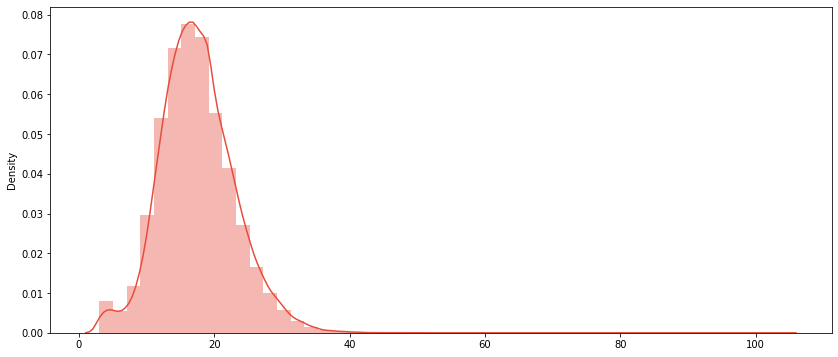

In [40]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [41]:
# Splitting the train test data after tokenizing.

train_bert = combined[:idx]
test_bert = combined[idx:]
train_bert.shape

(19538,)

In [42]:
# Label encoding clickbaits into 0/1 format where 1 is a clickbait
labels[labels == "clickbait"] = "yes-clickbait"
print(np.unique(labels))
le = LabelEncoder()
labels = le.fit_transform(labels)
print(train["truthClass"].head(2))

['no-clickbait' 'yes-clickbait']
0     no-clickbait
1    yes-clickbait
Name: truthClass, dtype: object


In [43]:
def tokenize_map(sentence, labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    global labels

    input_ids = []
    attention_masks = []
    
    for text in sentence:
        #   "encode_plus" will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = max_len,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [44]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train_bert, labels)
test_input_ids, test_attention_masks= tokenize_map(test_bert)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [45]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

15,630 training samples
3,908 validation samples


In [46]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [47]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [48]:
training_data = TensorDataset(input_ids, attention_masks)
training_sampler = SequentialSampler(training_data)
full_train_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

In [50]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))


The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [51]:
# Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [52]:
# We choose 2 or 3 as the number of epoch, more than this number produces overfitting
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [53]:
# Metric functions to measure the accuracy and F1-score which is (2*Precision*Recall)/(Precision+Recall)
# F1 score is used to balance the quantity (Recall TP/FN+TP) and the quality of the model (Precision TP/TP+FP)
# Accuracy is the percentage of cases correctly predicted, the dataset is unbalanced, so this is not the best metric

def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [54]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [55]:
#@title BERT Training code
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    
    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    
    model.train()

    # For each batch of training data...
    
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict = False)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        
        optimizer.step()

        # Update the learning rate.
        
        scheduler.step()

    # Calculate the average loss over all of the batches.
    
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    
    model.eval()

    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict = False)
            
        # Accumulate the validation loss.
        
        total_eval_loss += loss.item()

        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    50  of    489.    Elapsed: 0:00:50.
  Batch   100  of    489.    Elapsed: 0:01:40.
  Batch   150  of    489.    Elapsed: 0:02:30.
  Batch   200  of    489.    Elapsed: 0:03:21.
  Batch   250  of    489.    Elapsed: 0:04:11.
  Batch   300  of    489.    Elapsed: 0:05:01.
  Batch   350  of    489.    Elapsed: 0:05:51.
  Batch   400  of    489.    Elapsed: 0:06:41.
  Batch   450  of    489.    Elapsed: 0:07:31.

  Average training loss: 0.40
  Training epcoh took: 0:08:10

Running Validation...
  Accuracy: 0.85
  F1: 0.66
  Validation Loss: 0.34
  Validation took: 0:00:39

======== Epoch 2 / 2 ========
Training...
  Batch    50  of    489.    Elapsed: 0:00:50.
  Batch   100  of    489.    Elapsed: 0:01:40.
  Batch   150  of    489.    Elapsed: 0:02:30.
  Batch   200  of    489.    Elapsed: 0:03:20.
  Batch   250  of    489.    Elapsed: 0:04:10.
  Batch   300  of    489.    Elapsed: 0:05:01.
  Batch   350  of    489.    Elapsed: 0:05:51

##4) BERT Evaluation


In [56]:
# Display floats with four decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.3952,0.3354,0.8501,0.6594,0:08:10,0:00:39
2,0.3133,0.3320,0.8557,0.6795,0:08:09,0:00:39


In [57]:
# Prediction on Test

# Put model in evaluation mode:
model.eval()

# Tracking variables :
predictions = []

# Predict:
for batch in prediction_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:
  with torch.no_grad():
      # Forward pass, calculate logit predictions:
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:
  logits = logits.detach().cpu().numpy()
 
  # Store predictions and true labels:
  predictions.append(logits)


In [58]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [59]:
# Prediction on Train

# Put model in evaluation mode:
model.eval()

# Tracking variables :
train_predictions = []

# Predict:
for batch in full_train_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:
  with torch.no_grad():
      # Forward pass, calculate logit predictions:
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:
  logits = logits.detach().cpu().numpy()
 
  # Store predictions and true labels:
  train_predictions.append(logits)


In [60]:
flat_train_predictions = [item for sublist in train_predictions for item in sublist]
flat_train_predictions = np.argmax(flat_train_predictions, axis=1).flatten()

In [61]:
# TRAIN Accuracy
print('  Accuracy BERT model: {0:.4f}'.format(accuracy_score(flat_train_predictions, labels)))

# TRAIN F1-Score
print('  F1-Score BERT model: {0:.4f}'.format(f1_score(flat_train_predictions, labels)))

  Accuracy BERT model: 0.8773
  F1-Score BERT model: 0.7342


In [62]:
# Retrieve train labels in a separate numpy array & concatenate train/test texts
test_labels = test['truthClass'].values
test_labels[test_labels == "clickbait"] = "yes-clickbait"
test_labels = le.transform(test_labels)

In [63]:
# TEST Accuracy
print('  Accuracy BERT model: {0:.4f}'.format(accuracy_score(flat_predictions, test_labels)))

# TEST F1-Score
print('  F1-Score BERT model: {0:.4f}'.format(f1_score(flat_predictions, test_labels)))

# TEST Precision
print('  Precision BERT model: {0:.4f}'.format(precision_score(flat_predictions, test_labels)))

# TEST Recall
print('  Recall BERT model: {0:.4f}'.format(recall_score(flat_predictions, test_labels)))


  Accuracy BERT model: 0.8658
  F1-Score BERT model: 0.7066
  Precision BERT model: 0.6793
  Recall BERT model: 0.7362


In [64]:
# BERT scores dictionary
bert_scores = {}
bert_scores["Accuracy"] = accuracy_score(flat_predictions, test_labels)
bert_scores["F1-Score"] = f1_score(flat_predictions, test_labels)
bert_scores["Precision"] = precision_score(flat_predictions, test_labels)
bert_scores["Recall"] = recall_score(flat_predictions, test_labels)

## 5) EDA and Feature Engineering additional features 


We will process postMedia and postTimestamp features to check if there is a correlation between the weekday, time of the day, the post media type and our target variable.

In a second step, we are adding word count number from the text feature previously processed.

In [65]:
train_text.head(2)

,text,truthClass,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,UK’s response to modern slavery leaving victim...,no-clickbait,UK’s response to modern slavery leaving victim...,"[UK, ’, s, response, to, modern, slavery, leav...","[uk, ’, s, response, to, modern, slavery, leav...","[uk, ’, response, modern, slavery, leaving, vi...","[(uk, JJ), (’, NNP), (response, NN), (modern, ...","[(uk, a), (’, n), (response, n), (modern, a), ...","[uk, ’, response, modern, slavery, leave, vict...",uk ’ response modern slavery leave victim dest...
1,this is good,clickbait,this is good,"[this, is, good]","[this, is, good]",[good],"[(good, JJ)]","[(good, a)]",[good],good


In [66]:
train_feat.head(2)

,postMedia,postTimestamp,truthClass
0,[],Sat Apr 29 23:25:41 +0000 2017,no-clickbait
1,[],Sat Apr 29 20:41:34 +0000 2017,clickbait


We are getting a new feature to check if the observation has been posted with image or not.

In [67]:
train_feat['postImage'] = train_feat["postMedia"].str.contains("jpg|png").astype(int)
test_feat['postImage'] = test_feat["postMedia"].str.contains("jpg|png").astype(int)

In [68]:
train_feat.drop(columns=["postMedia"], inplace=True)

In [69]:
test_feat.drop(columns=["postMedia"], inplace=True)

We are getting a new column with the day of the week and another column with morning/afternoon/evening/night depending on the postTime timeframe. We are also using DT library to retrieve some basic information from postime has weekday and month.

In [70]:
def part_of_day(hour):
    moment = str()
    if 0 <= hour < 6:
      moment = "night"
    elif 6 <= hour < 12:
      moment = "morning"
    elif 12 <= hour < 18:
      moment = "afternoon"
    else:
      moment = "evening"
    return moment

In [71]:
def part_of_day_labeled(hour):
    moment = str()
    if 0 <= hour < 6:
      moment =  4
    elif 6 <= hour < 12:
      moment = 1
    elif 12 <= hour < 18:
      moment = 2
    else:
      moment = 3
    return moment

In [72]:
train_feat["date"] = pd.to_datetime(train_feat["postTimestamp"])
train_feat["weekday"] = train_feat["date"].dt.day_name()
train_feat["hour"] = train_feat["date"].dt.hour
train_feat["month"] = train_feat["date"].dt.month
train_feat["daypart"] = train_feat["hour"].apply(lambda x: part_of_day(x))
train_feat["daypart_labeled"] = train_feat["hour"].apply(lambda x: part_of_day_labeled(x))

In [73]:
test_feat["date"] = pd.to_datetime(test_feat["postTimestamp"])
test_feat["weekday"] = test_feat["date"].dt.day_name()
test_feat["hour"] = test_feat["date"].dt.hour
test_feat["month"] = test_feat["date"].dt.month
test_feat["daypart"] = test_feat["hour"].apply(lambda x: part_of_day(x))
test_feat["daypart_labeled"] = test_feat["hour"].apply(lambda x: part_of_day_labeled(x))

Let's do some EDA on these variables

In [74]:
# We can use this information if there is some value 
print(train_feat["weekday"].unique())
print(test_feat["weekday"].unique())
print(train_feat["daypart"].unique())
print(test_feat["daypart"].unique())
print(train_feat["daypart_labeled"].unique())
print(test_feat["daypart_labeled"].unique())

['Saturday' 'Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday']
['Saturday' 'Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday']
['evening' 'afternoon' 'morning' 'night']
['evening' 'afternoon' 'morning' 'night']
[3 2 1 4]
[3 2 1 4]


In [75]:
# We can use this information if there is some value, in production environment this could not be a good approach if we don't have information about all months
print(train_feat["month"].unique())
print(test_feat["month"].unique())

[ 4  3  2  1 12]
[ 4  3  2  1 12]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


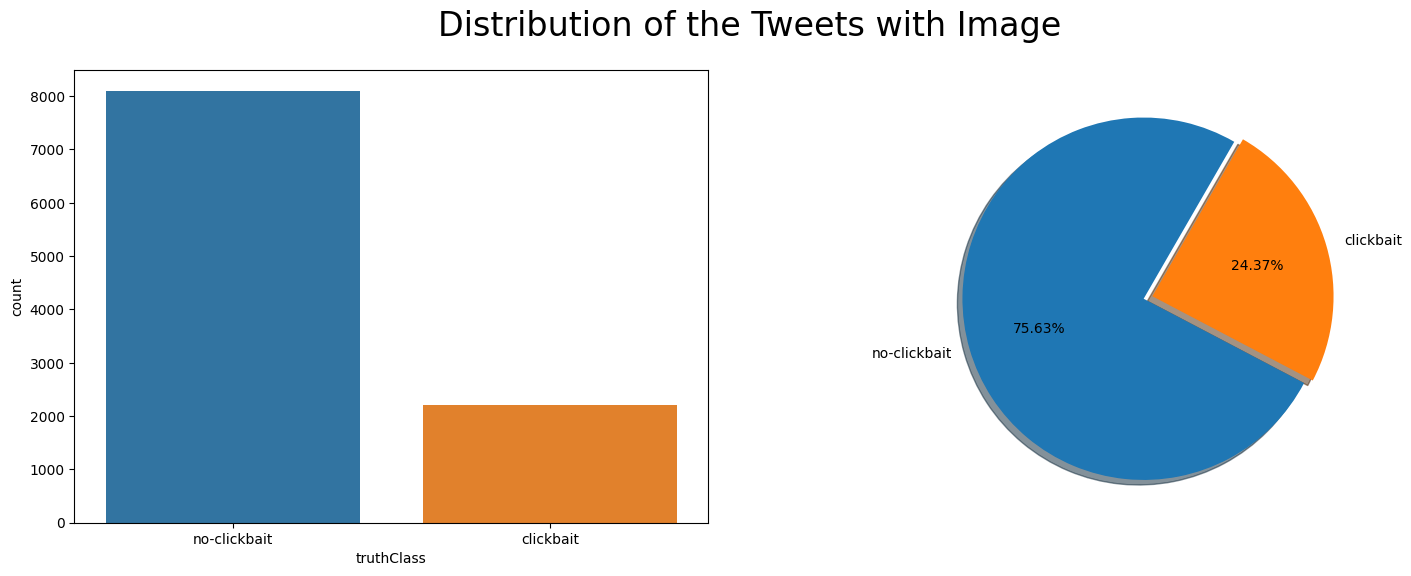

In [76]:
# Displaying target distribution based on posted image

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train_feat[train_feat["postImage"]==1]['truthClass'], ax=axes[0])
axes[1].pie(train_feat['truthClass'].value_counts(),
            labels=['no-clickbait', 'clickbait'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets with Image', fontsize=24)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


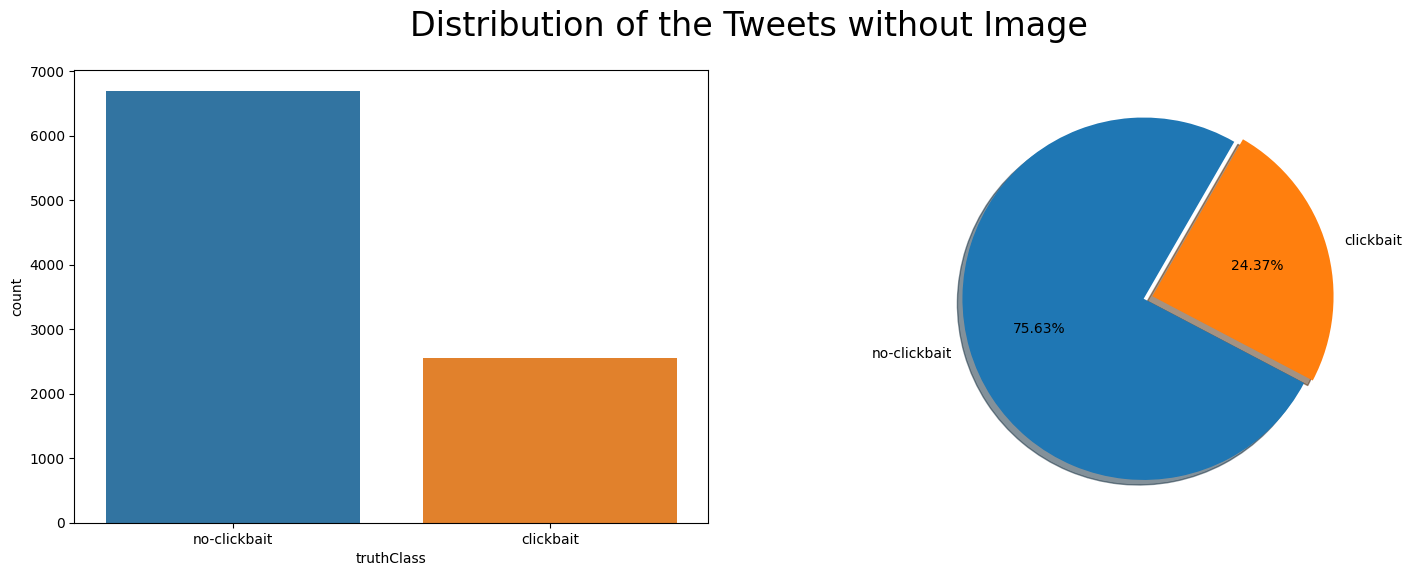

In [77]:
# Displaying target distribution based on posted image

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train_feat[train_feat["postImage"]==0]['truthClass'], ax=axes[0])
axes[1].pie(train_feat['truthClass'].value_counts(),
            labels=['no-clickbait', 'clickbait'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets without Image', fontsize=24)
plt.show()

It seems that the image doesn't impact the distribution of the label, therefore I am not adding this feature to the second model

In [78]:
train_feat["target"] = labels
test_feat["target"] = test_labels

Text(0, 0.5, '% of Clickbaits')

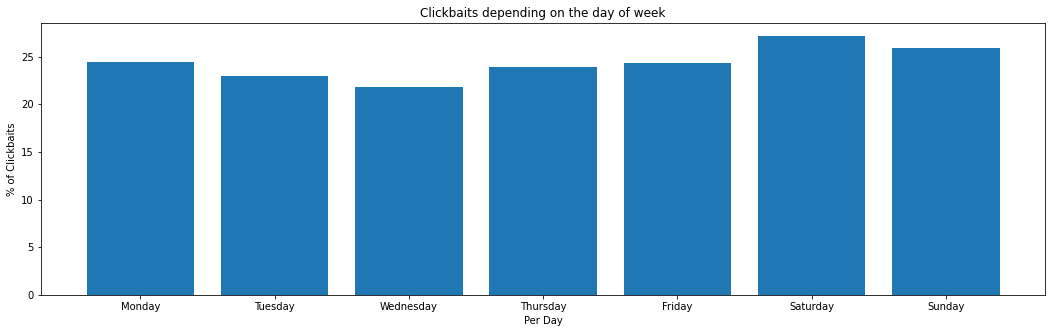

In [79]:
# Weekdays impact
click_day = {}
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday' ,'Sunday']
for day in weekdays:
  click_day[day] = 100*train_feat[train_feat["weekday"] == day]["target"].sum()/train_feat[train_feat["weekday"] == day]["target"].count()
f, ax = plt.subplots(figsize=(18,5))
plt.bar(click_day.keys(), click_day.values(), label="weekdays")
plt.title('Clickbaits depending on the day of week')
plt.xlabel('Per Day')
plt.ylabel('% of Clickbaits')

There are less proportion of clickbaits on Tuesdays and Wednesdays, a higher percentage from friday to monday

Text(0, 0.5, '% of Clickbaits')

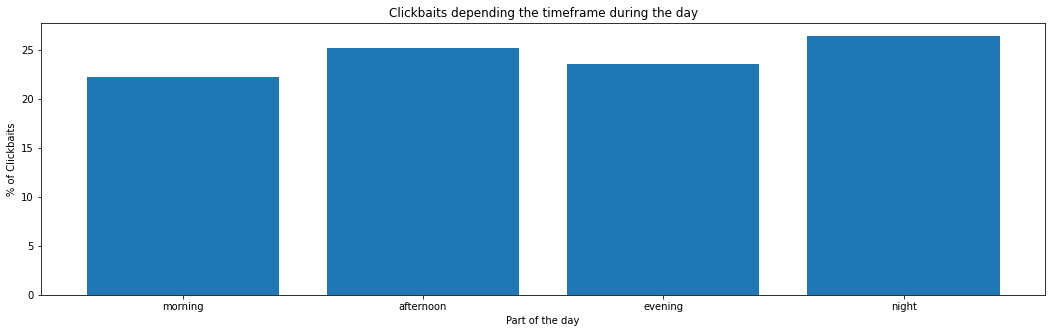

In [80]:
# Timeframe impact
part_day = {}
moments = ['morning', 'afternoon', 'evening', 'night']
for mom in moments:
  part_day[mom] = 100*train_feat[train_feat["daypart"] == mom]["target"].sum()/train_feat[train_feat["daypart"] == mom]["target"].count()
f, ax = plt.subplots(figsize=(18,5))
plt.bar(part_day.keys(), part_day.values())
plt.title('Clickbaits depending the timeframe during the day')
plt.xlabel('Part of the day')
plt.ylabel('% of Clickbaits')

The are less proportion of clickbaits during the morning and evening

In [81]:
list(train_feat["month"].unique())

[4, 3, 2, 1, 12]

Text(0, 0.5, '% of Clickbaits')

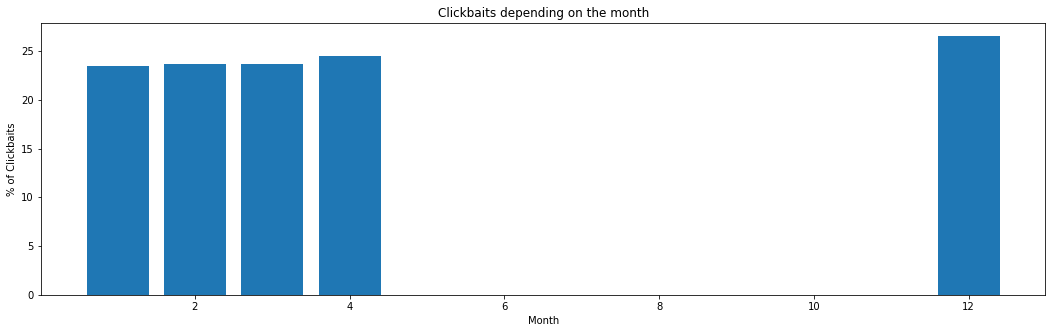

In [82]:
# Month impact
month = {}
months = list(train_feat["month"].unique())
for m in months:
  month[m] = 100*train_feat[train_feat["month"] == m]["target"].sum()/train_feat[train_feat["month"] == m]["target"].count()
f, ax = plt.subplots(figsize=(18,5))
plt.bar(month.keys(), month.values())
plt.title('Clickbaits depending on the month')
plt.xlabel('Month')
plt.ylabel('% of Clickbaits')

Higher amount of clickbaits during December month, it could be due to christmas holidays

#### Feature Engineering with number of words and time information

In [83]:
# Getting the weekdays in numerical 
train_feat["weekday"] = train_feat["date"].dt.weekday
test_feat["weekday"] = test_feat["date"].dt.weekday

In [84]:
# Retrieve number of words in each tweet
train_feat["text"] = train_text["text"]
test_feat["text"] = test_text["text"]
train_feat["n_words"] = train_feat["text"].apply(lambda x: len(x.split()))
test_feat["n_words"] = test_feat["text"].apply(lambda x: len(x.split()))

In [85]:
# We also want to use predictions from BERT model
train_feat["BERT"] =  flat_train_predictions
test_feat["BERT"] = flat_predictions

In [86]:
train_feat.drop(columns=["postTimestamp","truthClass","postImage","date", "hour", "daypart", "text"], inplace=True)
test_feat.drop(columns=["postTimestamp","truthClass","postImage","date", "hour", "daypart", "text"], inplace=True)

Time information as "part of the day", weekdays or months, needs to be coded in a different way as they are within a cycle. A proper approach to encode this information is by using angular distance calculating sin and cosin angles as follows. 


Full rotation 2pi is equal to 0

In [87]:
# Weekdays angular distance
train_feat['weekday_sin'] = np.sin(train_feat['weekday'] * (2 * np.pi / 7))
train_feat['weekday_cos'] = np.cos(train_feat['weekday'] * (2 * np.pi / 7))

test_feat['weekday_sin'] = np.sin(test_feat['weekday'] * (2 * np.pi / 7))
test_feat['weekday_cos'] = np.cos(test_feat['weekday'] * (2 * np.pi / 7))

In [88]:
# Month angular distance
train_feat['month_sin'] = np.sin(train_feat['month'] * (2 * np.pi / 12))
train_feat['month_cos'] = np.cos(train_feat['month'] * (2 * np.pi / 12))

test_feat['month_sin'] = np.sin(test_feat['month'] * (2 * np.pi / 12))
test_feat['month_cos'] = np.cos(test_feat['month'] * (2 * np.pi / 12))

In [89]:
# Month angular distance
train_feat['daypart_sin'] = np.sin(train_feat['daypart_labeled'] * (2 * np.pi / 4))
train_feat['daypart_cos'] = np.cos(train_feat['daypart_labeled'] * (2 * np.pi / 4))

test_feat['daypart_sin'] = np.sin(test_feat['daypart_labeled'] * (2 * np.pi / 4))
test_feat['daypart_cos'] = np.cos(test_feat['daypart_labeled'] * (2 * np.pi / 4))

In [90]:
# We don't need these columns
train_feat.drop(columns=["weekday", "month", "daypart_labeled"], inplace=True)
test_feat.drop(columns=["weekday", "month", "daypart_labeled"], inplace=True)

In [91]:
train_feat.head()

,target,n_words,BERT,weekday_sin,weekday_cos,month_sin,month_cos,daypart_sin,daypart_cos
0,0,12,0,-0.9749,-0.2225,0.866,-0.5,-1.0000e+00,-1.8370e-16
1,1,3,1,-0.9749,-0.2225,0.866,-0.5,-1.0000e+00,-1.8370e-16
2,0,15,0,-0.9749,-0.2225,0.866,-0.5,1.2246e-16,-1.0000e+00
3,1,7,1,-0.9749,-0.2225,0.866,-0.5,1.2246e-16,-1.0000e+00
4,0,16,0,-0.9749,-0.2225,0.866,-0.5,1.0000e+00,6.1232e-17


##6) Combining BERT output with other models

- We are combining BERT output with some numerical features into a new XGBoost classifier model (Boosting type) and random forest classifier model (Baggig type). 

- On the other hand, we will make use of model stacking as well. 

- The outputs from these complex combinations of transformers & decision trees models (level 0 - base), will be stacked into a simple meta-model (level 1 - meta), hopefully, providing a smooth interpretation of the predictions made by base models. As this is a classification task, we will use a simple logistic regression model.

- Let's check if this strategy improves our scores compared to our single BERT.

- In the next chapter we will compare the results from the different outputs predictions (green boxes): BERT vs RF vs XGBOOST vs META

- Model Diagram:

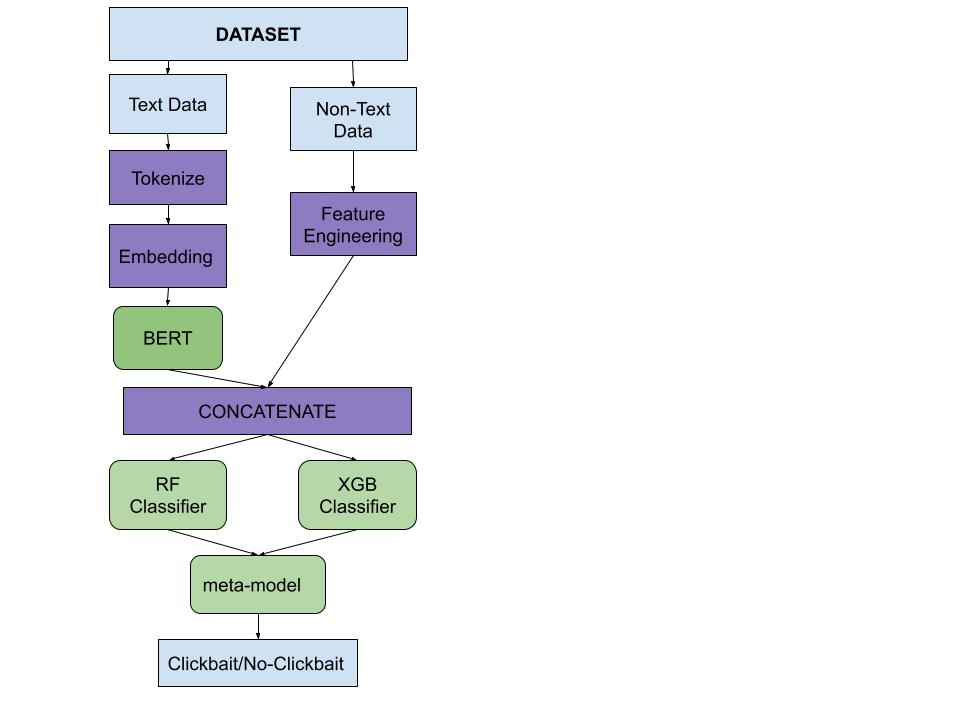





In [92]:
# Create train and validation sets and labels
y = train_feat["target"]
X = train_feat.drop(columns=["target"])

In [93]:
# Random train test split with 75/25 percentages
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=seed_val)

In [94]:
# Split test features and label into X y datasets
y_test = test_feat["target"]
X_test = test_feat.drop(columns=["target"])

In [95]:
#https://xgboost.readthedocs.io/en/stable/parameter.html
xgb_model = XGBClassifier(max_depth=8, #maximum depth of a tree
                         n_estimators=50,  #number of decision trees
                         colsample_bytree=0.5, #is the subsample ratio of columns when constructing each tree
                         subsample=0.5, #subsample ratio of training instances, it prevents overfitting
                         eta=0.3) #default learning rate

In [96]:
#Custom evaluation metric, the dataset is imbalanced
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [97]:
# We tried with custom F1_EVAL metric but it performs slightly better with evaluation metric 'auc'
xgb_model.fit(X_train, 
              y_train, 
              eval_metric='auc', 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              verbose=20, 
              early_stopping_rounds=20)

[0]	validation_0-auc:0.826321	validation_1-auc:0.818305
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[20]	validation_0-auc:0.856984	validation_1-auc:0.826894
[40]	validation_0-auc:0.871544	validation_1-auc:0.823989
Stopping. Best iteration:
[21]	validation_0-auc:0.857878	validation_1-auc:0.827069



XGBClassifier(colsample_bytree=0.5, eta=0.3, max_depth=8, n_estimators=50,
              subsample=0.5)

In [98]:
# Predictions from XGBoost Model
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_valid)
xgb_test_pred = xgb_model.predict(X_test)

In [99]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=seed_val, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [100]:
# Predictions from Random Forest Model
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_valid)
rf_test_pred = rf_model.predict(X_test)

Base level models are completed at this stage. We are creating new dataset to feed the meta model.

In [101]:
# Creating dataset to train the meta model
first_level = pd.DataFrame(xgb_val_pred, columns=['xgb'])
first_level['random_forest'] = rf_val_pred

In [102]:
# Creating test dataset from base level predictions
first_level_test = pd.DataFrame(xgb_test_pred, columns=['xgb'])
first_level_test['random_forest'] = rf_test_pred

In [103]:
# Training the model with first level outputs
second_model = LogisticRegression()
second_model.fit(first_level, y_valid)

LogisticRegression()

In [104]:
# Predictions on full training dataset and test dataset
ensemble_pred = second_model.predict(first_level)
final_predictions = second_model.predict(first_level_test)

In [105]:
print('VALIDATION DATASET RESULTS')

# TRAIN Accuracy
print('  Accuracy ensemble model: {0:.4f}'.format(accuracy_score(ensemble_pred, y_valid)))

# TRAIN F1-Score
print('  F1_score ensemble model: {0:.4f}'.format(f1_score(ensemble_pred, y_valid)))

# TRAIN Precision-Score
print('  Precision ensemble model: {0:.4f}'.format(precision_score(ensemble_pred, y_valid)))

# TRAIN Recall-Score
print('  Recall ensemble model: {0:.4f}'.format(recall_score(ensemble_pred, y_valid)))

VALIDATION DATASET RESULTS
  Accuracy ensemble model: 0.8762
  F1_score ensemble model: 0.7239
  Precision ensemble model: 0.6807
  Recall ensemble model: 0.7729


In [106]:
print('TEST DATASET RESULTS')

# TEST Accuracy
print('  Accuracy ensemble model: {0:.4f}'.format(accuracy_score(final_predictions, y_test)))

# TEST F1-Score
print('  F1_score ensemble model: {0:.4f}'.format(f1_score(final_predictions, y_test)))

# TEST Precision-Score
print('  Precision ensemble model: {0:.4f}'.format(precision_score(final_predictions, y_test)))

# TEST Recall-Score
print('  Recall ensemble model: {0:.4f}'.format(recall_score(final_predictions, y_test)))

TEST DATASET RESULTS
  Accuracy ensemble model: 0.8658
  F1_score ensemble model: 0.7066
  Precision ensemble model: 0.6793
  Recall ensemble model: 0.7362


In [107]:
# Combined model BERT text output with numerical features into XGBoost
xgb_scores = {}
xgb_scores["Accuracy"] = accuracy_score(xgb_test_pred, y_test)
xgb_scores["F1-Score"] = f1_score(xgb_test_pred, y_test)
xgb_scores["Precision"] = precision_score(xgb_test_pred, y_test)
xgb_scores["Recall"] = recall_score(xgb_test_pred, y_test)

In [108]:
# Combined model BERT text output with numerical features into RFClassifier
rf_scores = {}
rf_scores["Accuracy"] = accuracy_score(rf_test_pred, y_test)
rf_scores["F1-Score"] = f1_score(rf_test_pred, y_test)
rf_scores["Precision"] = precision_score(rf_test_pred, y_test)
rf_scores["Recall"] = recall_score(rf_test_pred, y_test)

In [109]:
# Ensemble model dictionary by stacking RF and XGBoost into logistic meta-model
ensemble_scores = {}
ensemble_scores["Accuracy"] = accuracy_score(final_predictions, y_test)
ensemble_scores["F1-Score"] = f1_score(final_predictions, y_test)
ensemble_scores["Precision"] = precision_score(final_predictions, y_test)
ensemble_scores["Recall"] = recall_score(final_predictions, y_test)

##7) Final Evaluation



#### The metrics we are using to score the performance of this model are: Accuracy, F1_Score, Precision and Recall. 


First of all we will define what are the following concepts:
 - True: Correct prediction
 - False: Wrong prediction
 - Positive: Clickbait
 - Negative: No-Clickbait

CONFUSION MATRIX:


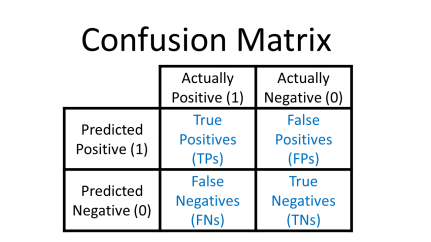

METRICS:
- Accuracy is the proportion of correct predictions vs the total number of predictions, independently to the type of observation (True = Clickbait vs False = No-Clickbait).
- Precision is the relation between the number of correctly predicted clickbaits and the total of clickbait predictions. This is a measure of the model quality.
- Recall is the relation between the number of correctly predicted clickbaits and the real number of clickbaits in the dataset.
- F1-Score is a balanced measure between Precision/Recall, it's computed as: 
2xPrecisionxRecall/(Precision+Recall). It's a mix between quality and quantity of correct clickbait predictions, that this model is able to achieve.

Due to the fact that observations are imbalanced, and in real scenario we would have less clickbaits than clickbaits, accuracy it's not a good measure for this task. We will focus on F1-Score, for example, to determine the performance from the different model variations. There are other metrics from confusion matrix, it depends on the situation and what is more desirable.

#### BERT Performance depending on the number of epochs



- Batch size is the number of training samples the algorithm uses to compute the loss, and backpropagate to tune the internal parameters of the deep learning model. 

- Epoch is the number of time the model trains over the full training dataset. Increasing this value could overfit the model and achieve poor performance in production environment.

- We had train with 6 epochs BERT model to determine the best number of epoch via validation loss. We will plot a table with the different performances.

In [110]:
#@title BERT Performances vs Nº Epochs
# TrainingLoss	Valid.Loss	Valid.Accur.	Val_F1	TrainingTime	ValidationTime
#epoch						
#1	0.40	0.34	0.85	0.66	0:08:05	0:00:39
#2	0.31	0.34	0.85	0.70	0:08:04	0:00:39
#3	0.27	0.33	0.86	0.70	0:08:04	0:00:39
#4	0.23	0.35	0.85	0.68	0:08:04	0:00:39
#5	0.20	0.39	0.85	0.67	0:08:04	0:00:39
#6	0.18	0.40	0.85	0.68	0:08:05	0:00:39

bert_epoch_stats = []

# epoch 1
bert_epoch_stats.append(
        {
            'epoch': 1,
            'Training Loss': 0.40,
            'Valid. Loss': 0.34,
            'Valid. Accur.': 0.85,
            'Val_F1' : 0.66
        }
    )

# epoch 2 
bert_epoch_stats.append(
        {
            'epoch': 2,
            'Training Loss': 0.31,
            'Valid. Loss': 0.34,
            'Valid. Accur.': 0.85,
            'Val_F1' : 0.70
        }
    )

# epoch 3
bert_epoch_stats.append(
        {
            'epoch': 3,
            'Training Loss': 0.27,
            'Valid. Loss': 0.33,
            'Valid. Accur.': 0.86,
            'Val_F1' : 0.70
        }
    )

# epoch 4 
bert_epoch_stats.append(
        {
            'epoch': 4,
            'Training Loss': 0.23,
            'Valid. Loss': 0.35,
            'Valid. Accur.': 0.85,
            'Val_F1' : 0.68
        }
    )

# epoch 5
bert_epoch_stats.append(
        {
            'epoch': 5,
            'Training Loss': 0.20,
            'Valid. Loss': 0.39,
            'Valid. Accur.': 0.85,
            'Val_F1' : 0.67
        }
    )

# epoch 6
bert_epoch_stats.append(
        {
            'epoch': 6,
            'Training Loss': 0.18,
            'Valid. Loss': 0.40,
            'Valid. Accur.': 0.85,
            'Val_F1' : 0.68
        }
    )

In [111]:
# BERT performance vs Nº Epochs

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
bert_epoch = pd.DataFrame(data=bert_epoch_stats)

# Use the 'epoch' as the row index.
bert_epoch = bert_epoch.set_index('epoch')

# Display the table.
display(bert_epoch)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1
epoch,,,,
1,0.40,0.34,0.85,0.66
2,0.31,0.34,0.85,0.70
3,0.27,0.33,0.86,0.70
4,0.23,0.35,0.85,0.68
5,0.20,0.39,0.85,0.67
6,0.18,0.40,0.85,0.68


It's clear that as of epoch number 2 and 3 the model starts to overfit. We can choose an epoch between 2 and 3, but not higher than this value.

#### Performance depending on the model type

In [112]:
# Performances
model_types = [("BERT", bert_scores), ("BERT-XGB", xgb_scores), ("BERT-RF", rf_scores), ("STACKED", ensemble_scores)]
model_performances = []
for model_type in model_types:
  model_performances.append(
      {
          'Model': model_type[0],
          'Accuracy': model_type[1]["Accuracy"],
          'F1-Score': model_type[1]["F1-Score"],
          'Precision': model_type[1]["Precision"],
          'Recall' : model_type[1]["Recall"]
       
      }
  )

In [113]:
# Display floats with four decimal places.
pd.set_option('precision', 6)

# Create a DataFrame from our training statistics.
model_perform = pd.DataFrame(data=model_performances)

# Use the 'epoch' as the row index.
model_perform = model_perform.set_index('Model')

# Display the table.
display(model_perform)

,Accuracy,F1-Score,Precision,Recall
Model,,,,
BERT,0.865799,0.706601,0.679291,0.736198
BERT-XGB,0.865799,0.706601,0.679291,0.736198
BERT-RF,0.865799,0.706668,0.679513,0.736084
STACKED,0.865799,0.706601,0.679291,0.736198


**- Discussion about the results**

In some executions, we have achieved slightly better results by combining non-text features along to BERT transformers predictions. In some cases with RF Classifier, in others with XGBoost, but in other runs we couldn't achieved a better performance with this strategy than with the single BERT model. So there isn't a significance improvement in the machine learning system by adding non-text features in this way.

By stacking the outputs from XGBoost and Random Forest Tree into the meta-model we've found out that there isn't any improvement on the metrics. This is mainly caused because the predictions from XGBoost and RF are highly dependant to BERT-Transformers, therefore thay are highly correlated. Under this circumstance stacking these base models is not helpful.

**BERT-Transformers** is the model which is capturing the main part of information in order to correctly predict a clickbait tweet. It seems that decision tree's based algorithm, in some runs, were able to capture non-text information and combined this with NLP data achieving a small enhancement. 

##8) Error Analysis
 

Let's go through test wrong predictions and try to analyze what is avoiding the model to perform better.

In [114]:
errors = pd.DataFrame()
# No clickbait - False Positive
# Actual clickbait - False Negative
errors["text"] = test["postText"]
errors["label"] = y_test
errors["preds"] = flat_predictions
errors["error"] = errors["preds"]!=errors["label"]
errors = errors.drop(errors[errors.error == False].index)
errors.reset_index(inplace=True, drop=True)
errors["False"] = errors["label"]==0 # false_positive, not really a clickbait
errors["False"] = errors["False"].apply(lambda x: "Positive" if x == True else "Negative")

In [115]:
errors

,text,label,preds,error,False
0,Don't abandon the snot if you want to be healt...,0,1,True,Positive
1,He worked in a factory floor. He now helps bui...,1,0,True,Negative
2,"Congratulations, Kalpit Veerval 👏",1,0,True,Negative
3,Jealous wife chops off her husband's PENIS wit...,1,0,True,Negative
4,Latest Uber controversy sheds light on how com...,1,0,True,Negative
...,...,...,...,...,...
2542,This guy re-creates famous movie scenes with h...,0,1,True,Positive
2543,Is race the reason why people want to see a Ma...,1,0,True,Negative
2544,"The war for talent is on, and it's getting int...",1,0,True,Negative
2545,These were the top most Instagrammed locations...,0,1,True,Positive


In [116]:
errors["text"][16]

"The fascinating hidden history of London's lost rivers"

In [117]:
errors["text"][1]

'He worked in a factory floor. He now helps build the robots that are replacing human labor'

Checking two random tweets we've found out that our model is performing well. Even myself I could think that 'The fascinating hidden history of London's lost rivers' could be a clickbait tweet. The word fascinating is kind of suspicious.

On the other hand, the false negative 'He worked in a factory floor. He now helps build the robots that are replacing human labor' seems to be a regular news, but it's actually looking for factory workers fearing losing their jobs to click on the tweet.


In [118]:
errors["text"] = errors["text"].astype(str)
errors['text_clean'] = errors['text'].apply(lambda x: remove_URL(x))
errors['text_clean'] = errors['text_clean'].apply(lambda x: remove_emoji(x))
errors['text_clean'] = errors['text_clean'].apply(lambda x: remove_html(x))
errors['text_clean'] = errors['text_clean'].apply(lambda x: remove_punct(x))
errors['tokenized'] = errors['text_clean'].apply(word_tokenize)
errors['lower'] = errors["tokenized"].apply(lambda x: [word.lower() for word in x])
errors["stopwords_removed"] = errors['lower'].apply(lambda x: [word for word in x if word not in stop])
errors['pos_tags'] = errors['stopwords_removed'].apply(nltk.tag.pos_tag)

errors['wordnet_pos'] = errors['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

errors['lemmatized'] = errors['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

errors['lemmatized'] = errors['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

errors['lemma_str'] = errors['lemmatized']
for idx in range(0, len(errors['lemmatized'])):
  errors['lemma_str'][idx] = ' '.join(map(str, errors['lemmatized'][idx]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


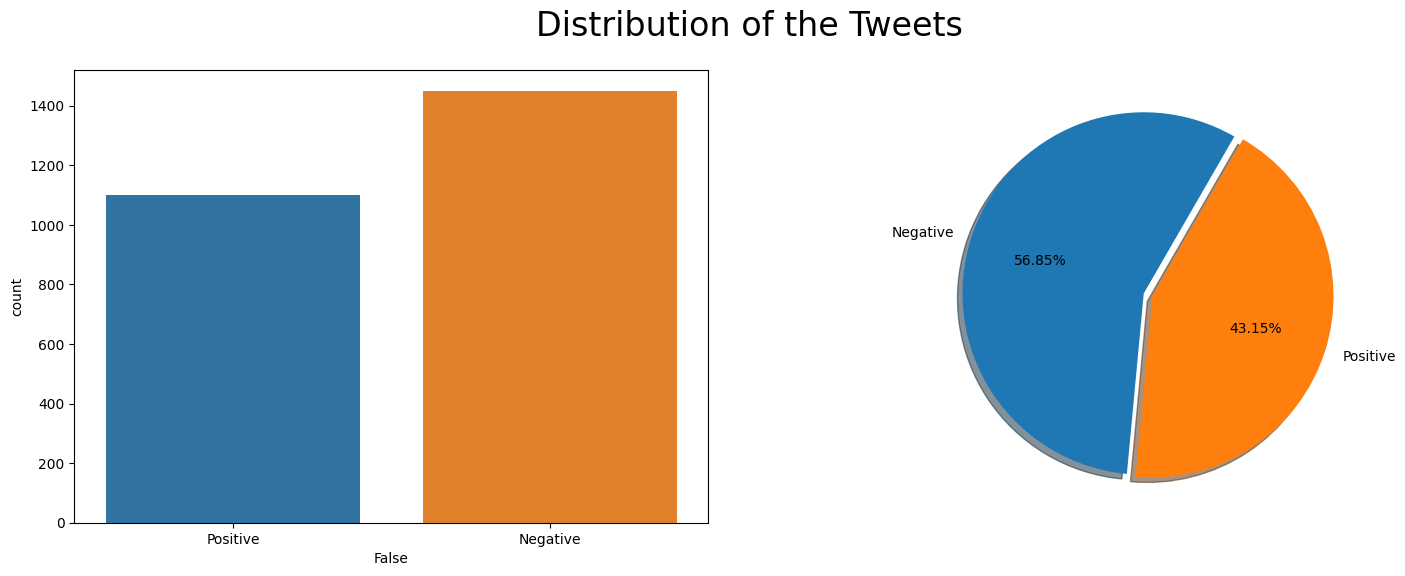

In [119]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(errors["False"], ax=axes[0])
axes[1].pie(errors["False"].value_counts(),
            labels=['Negative', 'Positive'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()


There are more false negatives than false positives, taken into consideration that there are much more cases of non-clickbaits and that the error proportion is almost the 50/50, it indicates that is harder for the model to detect clickbaits than non-clickbaits.

In [120]:
error_list_labels = [
    errors[errors['False'] == "Negative"]['lemma_str'],
    errors[errors['False'] == "Positive"]['lemma_str']
]

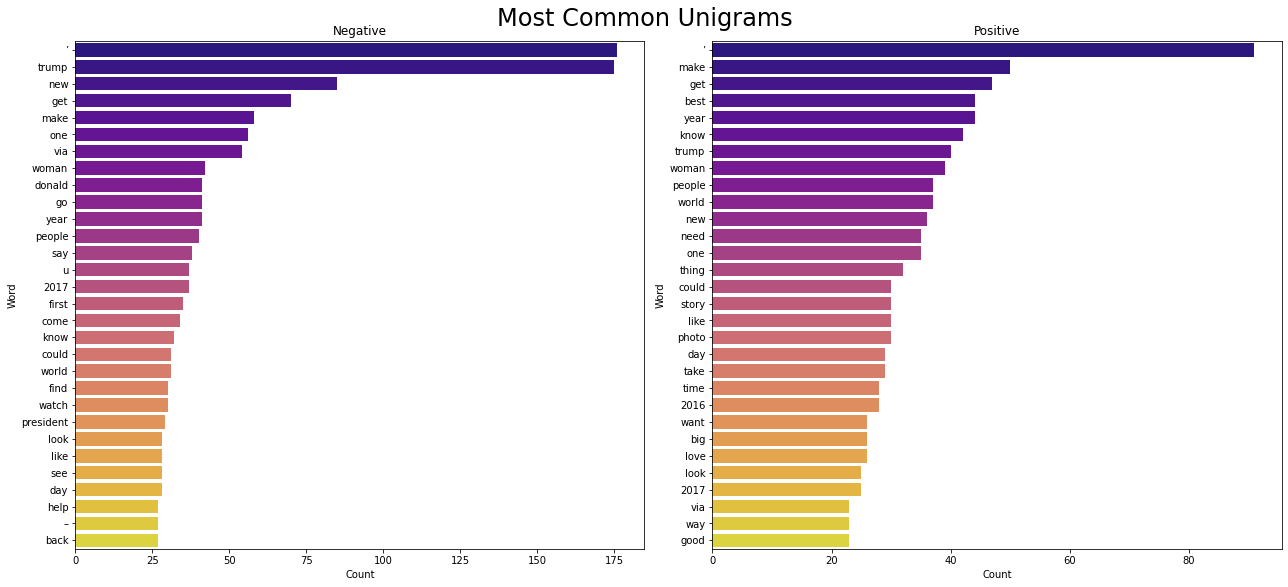

In [121]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(error_list_labels, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)

axes[0].set_title('Negative')
axes[1].set_title('Positive')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

If we compare this result with most common unigrams in clickbaits/no-clickbait we can find that in the cases of false positives the system is failing with words very frequent in clickbait tweets such as: get, make, new, 2016, 2017, know or need.

In the case of false negatives, we also see that the unigrams looks similar to non-clickbaits most common unigrams. 

*See and compare to chapter 2.*

In [122]:
def errngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(error_list_labels, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Negative')
        axes[1].set_title('Positive')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

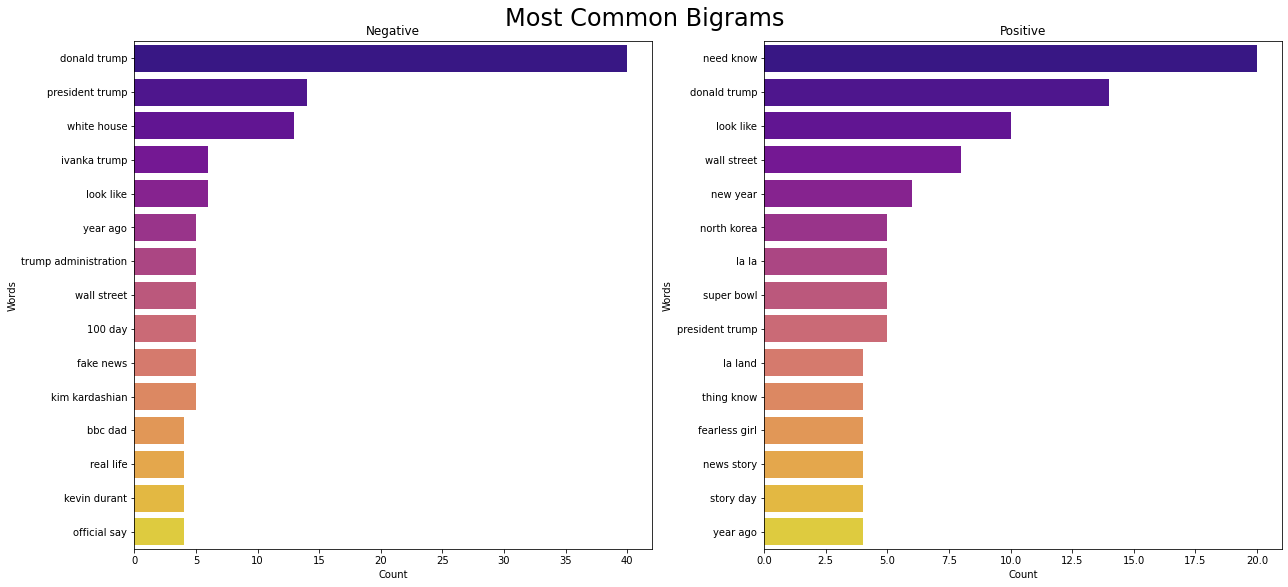

In [123]:
errngrams(2, 'Most Common Bigrams')

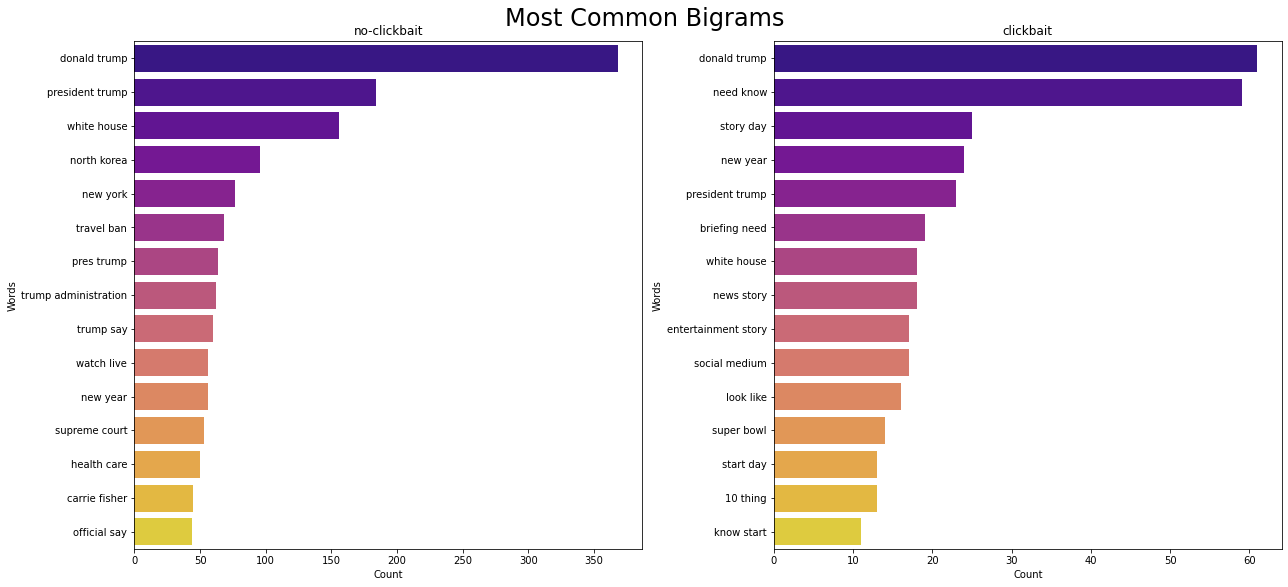

In [124]:
ngrams(2, 'Most Common Bigrams')

We can also appreciate some similarities between:

- False negatives & non-clickbaits
For example, "trump administration" is one of the bigrams most frequent in non-clickbait tweets, and it's also one of the most frequents in false negative. 

- False positives & clickbaits
For example, "need know" is one of the bigrams most frequent in clickbait tweets, and it's also one of the most frequents in false positives. 


##9) To Do List

In order to delve into this topic, and to enhance the model, we think that there are several steps that could be done for these reasons.

- Implement an AI system with Recursive Neural Networks as GRU and LSTM, the average number of words per tweet is not so big (between 10 and 15 words). It can be interesting to compare the results from these models with BERT. In any case, the state of the art researches indicates that transformers performs better in NLP tasks and are more efficient than clasical RNN's.

- We could try to add more regularization to prevent overfitting the model during the training, by adding a dropout layer for example.

- It can be interesting to finetune some hyperparameters like the batch size. Try with other optimization algorithms  in stochastic gradient descent, or do not lower case the words when training BERT model (my intuition tells me that upper case letters and punctuations could imply clickbaiting).

- CrossValidation usually fits better than train/validation split, with StratifiedKFold we can split the training dataset into 5-10 smaller subdatasets preserving the percentage of samples for each class.

- Using more text features available in both datasets. Note that during this task we haven't make use of additional information within the dataset before training the transformer model, as the keywords for example. These features could have lead us to get better results. 

- More feature engineering. Also, some of the non-text variables which have been processed in a second model, can be passed directly to BERT model by modifying them into text format. For example, if the tweet has been posted on a Monday, we can add a column "weekday" with the value "This tweet has been posted on a Monday".

- Data augmentation. We could try to artificially create further training examples, there are sophisticated approaches as back translation, which translates the text into another language, then it's re-translated back to the original language, this way we can have the same meaning but with different words. There are also other simpler ways, like synonym replacement.

##10) References


- https://www.kaggle.com/code/datafan07/disaster-tweets-nlp-eda-bert-with-transformers
- https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
- https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
- https://huggingface.co/docs/transformers/index
- https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/
- https://towardsdatascience.com/how-to-combine-textual-and-numerical-features-for-machine-learning-in-python-dc1526ca94d9
- https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/